## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
import zarr
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [2]:
### TODO: Google Cloud data access and opening

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
filename = 'tc_sar_data.zarr'

### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)

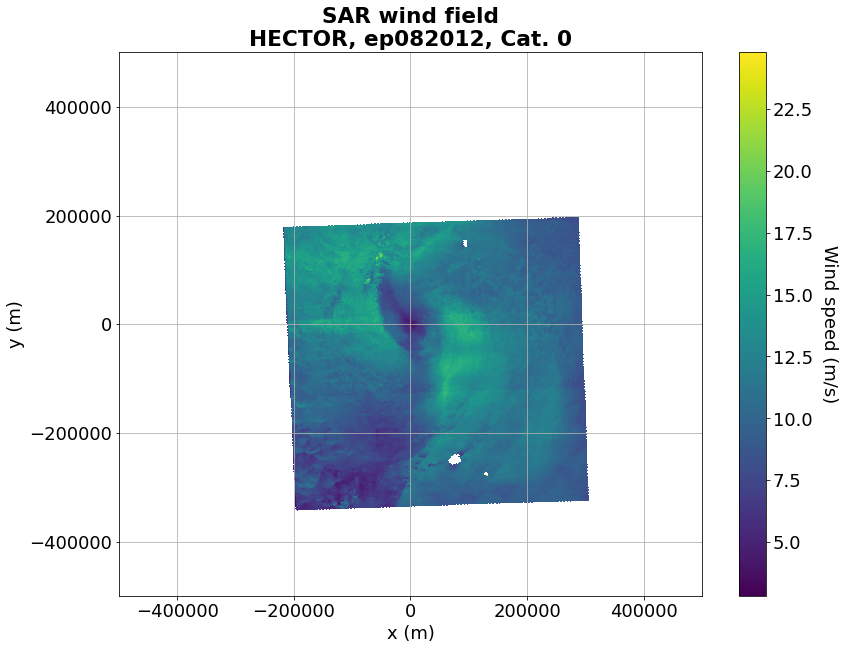

In [3]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                 # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
plot_wind_field(ds_all, time_idx=0)

Indexes for HECTOR:  [  0  85  86  87 154 155 269 270]


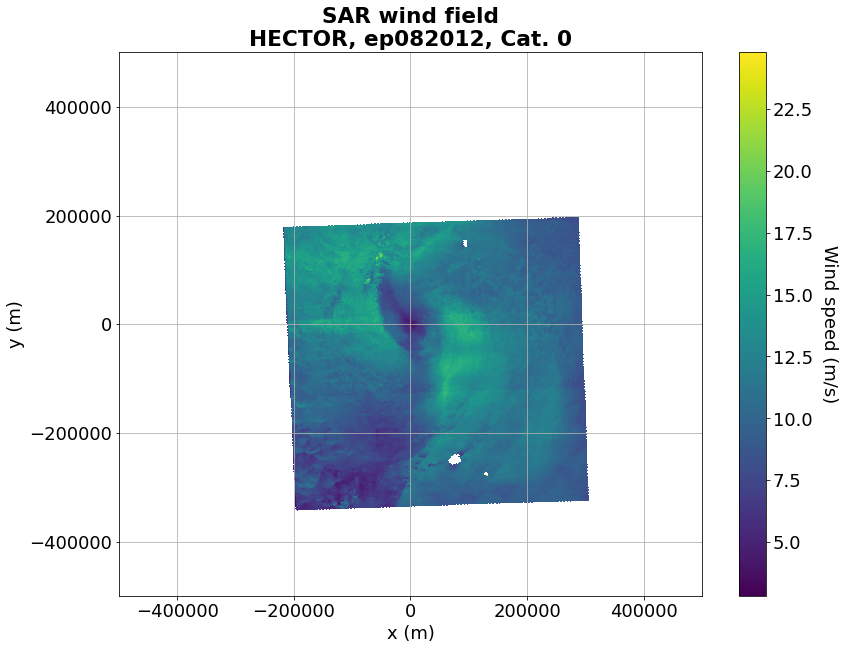

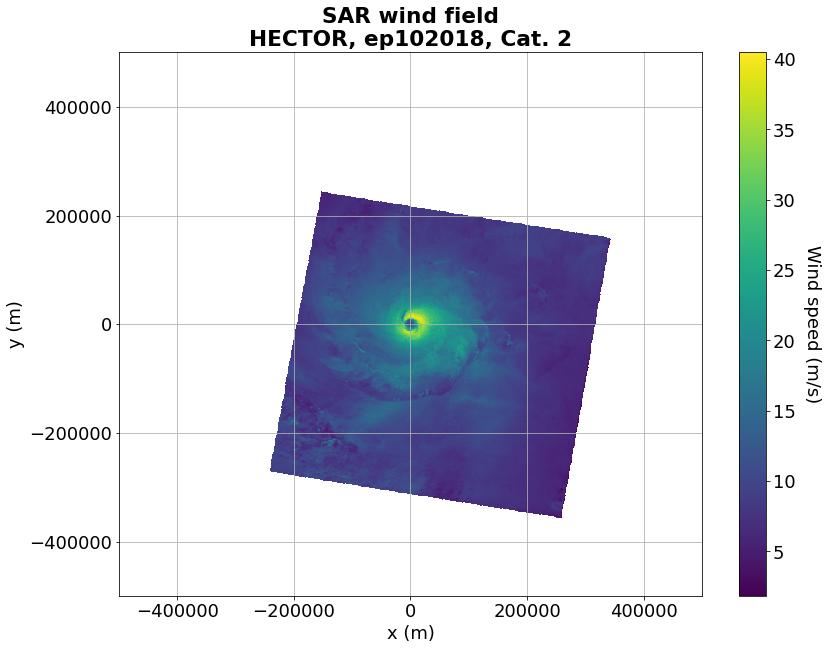

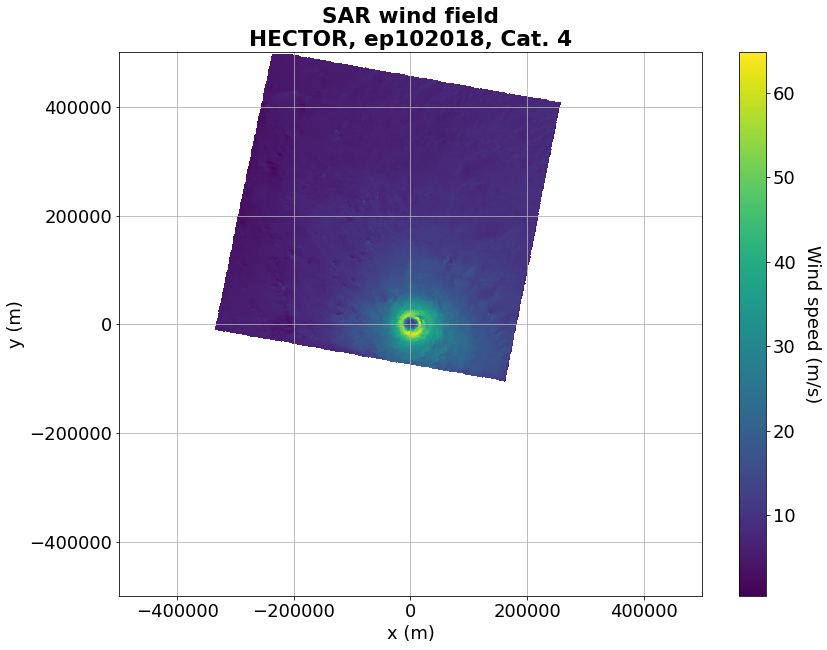

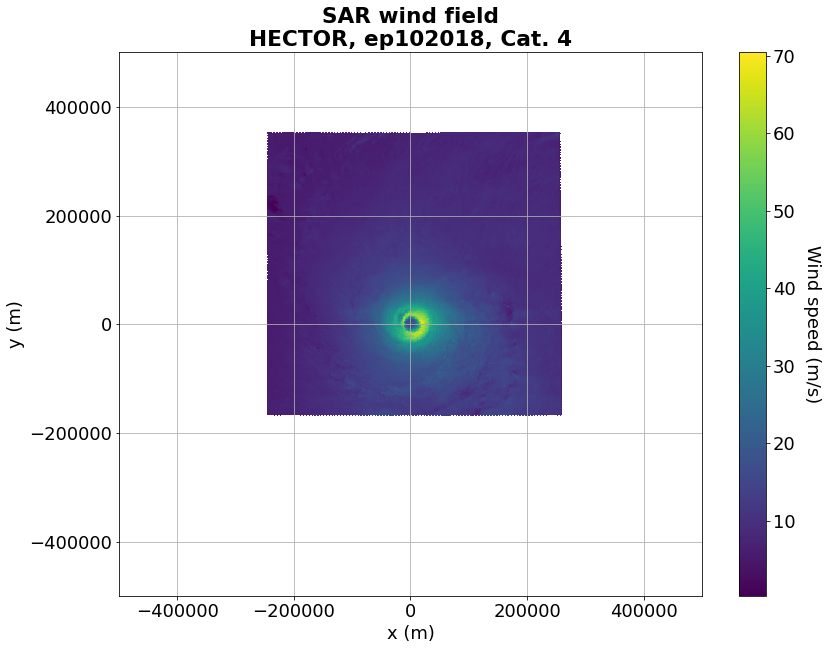

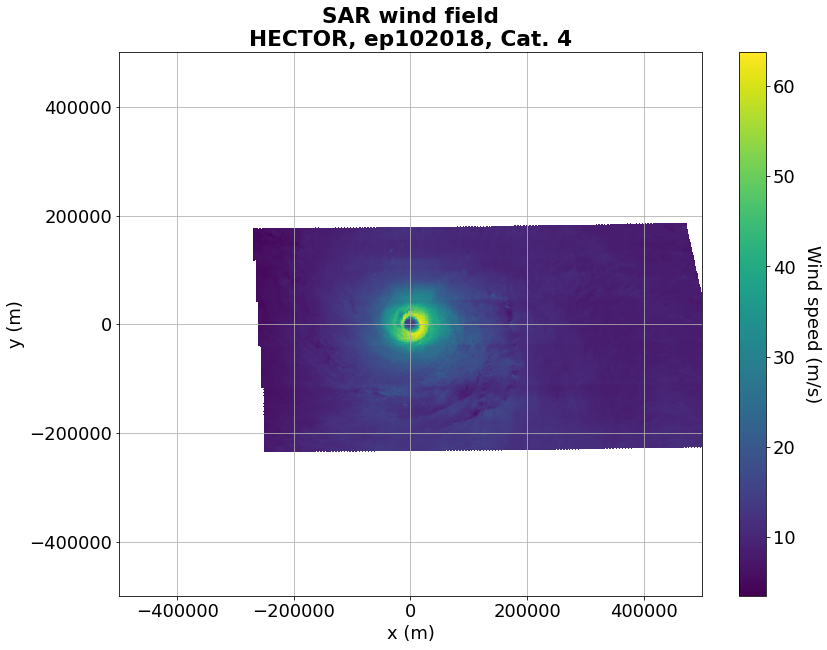

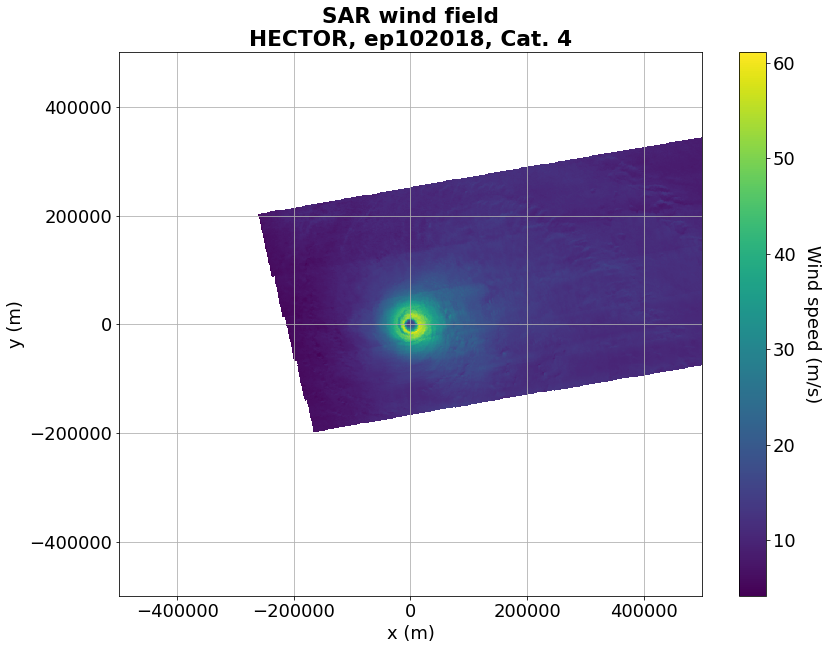

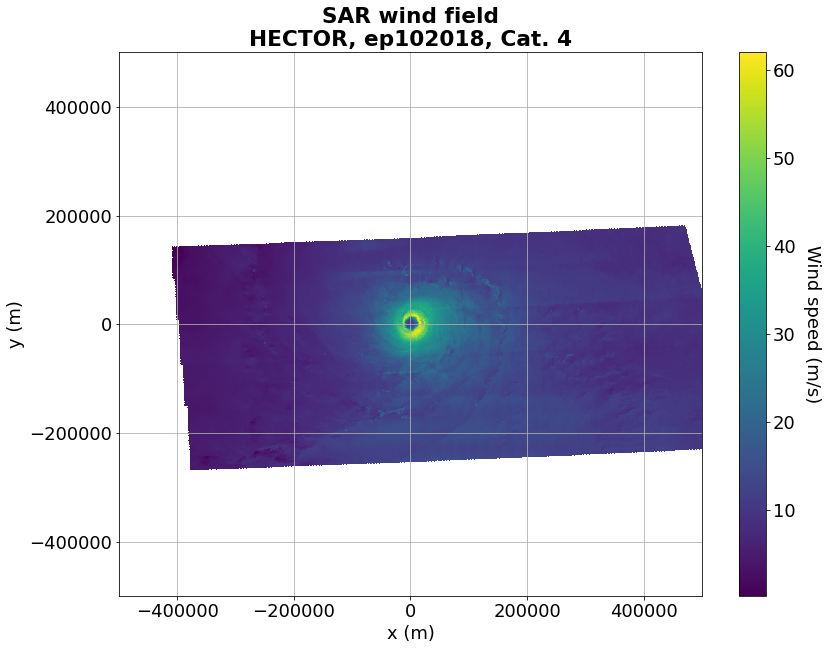

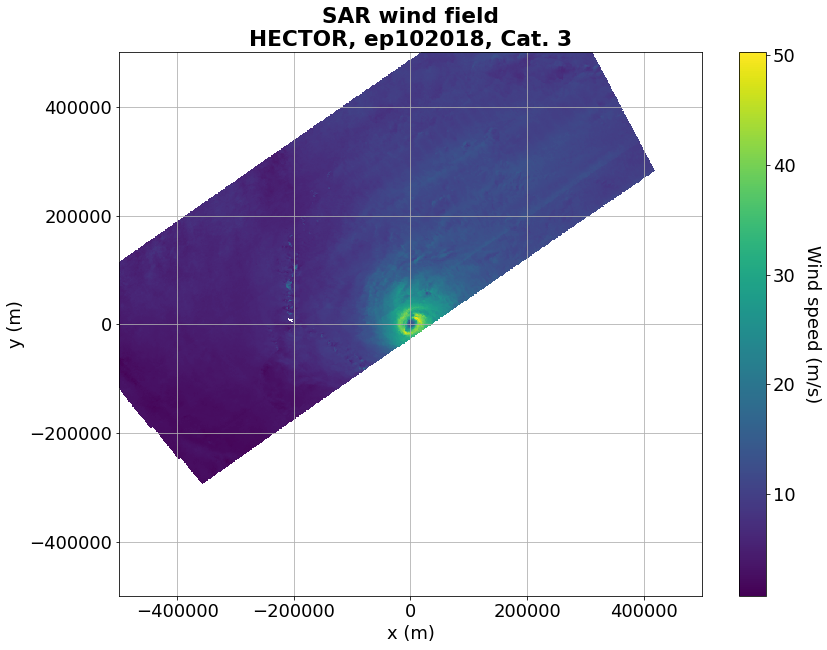

In [4]:
### FIND ALL TIME INDEXES FROM NAME AND PLOT ALL CORRESPONDING OBSERVATIONS
def find_time_idx(ds_all, storm_name):
    return np.where(ds_all['storm_name']==storm_name)[0]

storm_name = 'HECTOR'
print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
for time_idx in find_time_idx(ds_all, storm_name):
    plot_wind_field(ds_all, time_idx)

In [ ]:
%%time
### DISPLAY AVERAGE WIND FIELD
mean_ws = np.nanmean(ds_all['wind_speed'], axis=0)
plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()

Cat. 0 = 92
Cat. 1 = 82
Cat. 2 = 41
Cat. 3 = 55
Cat. 4 = 54
Cat. 5 = 17


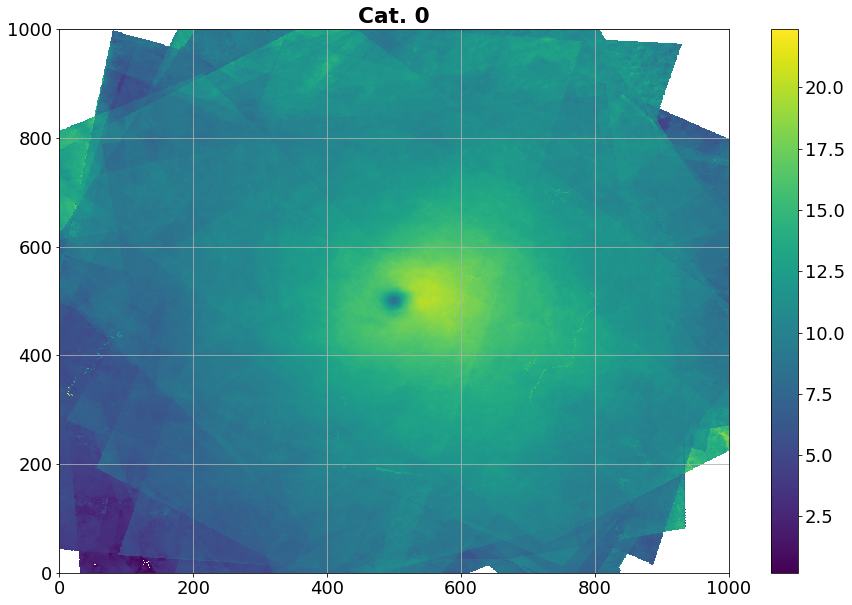

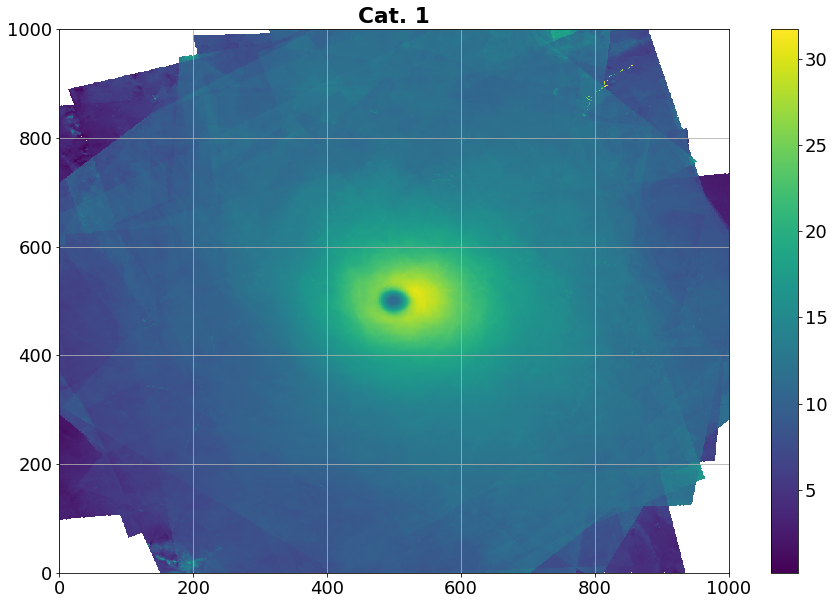

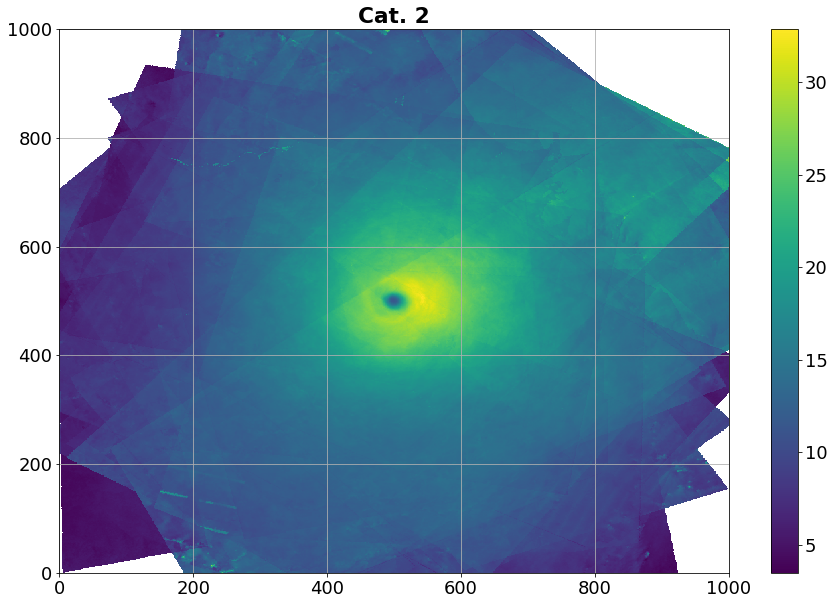

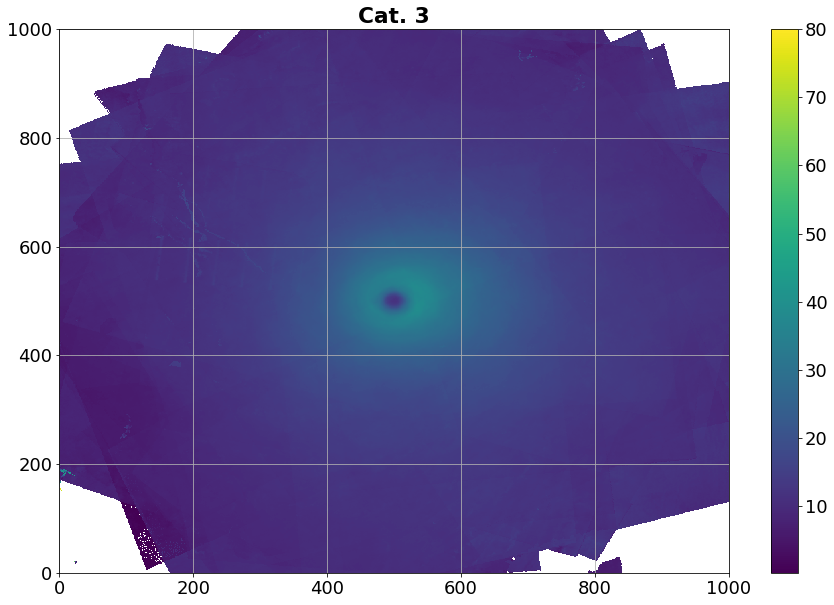

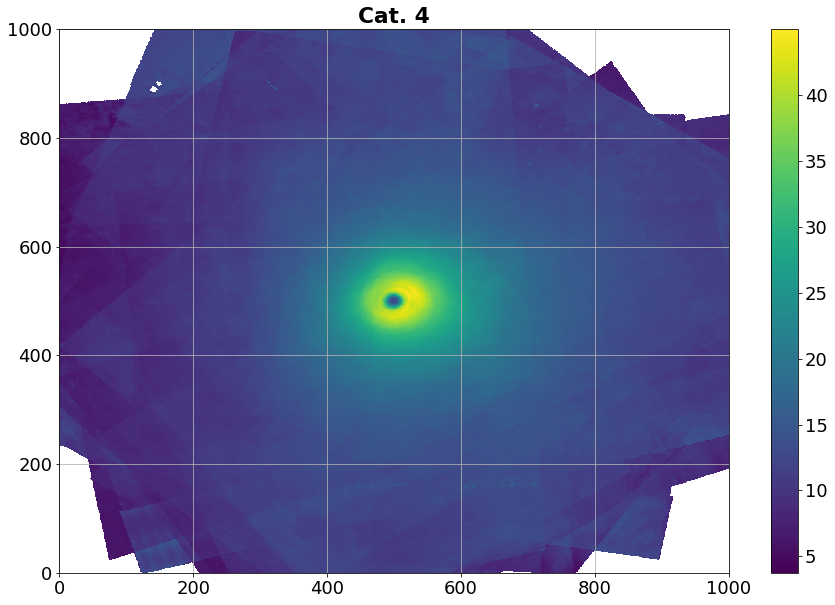

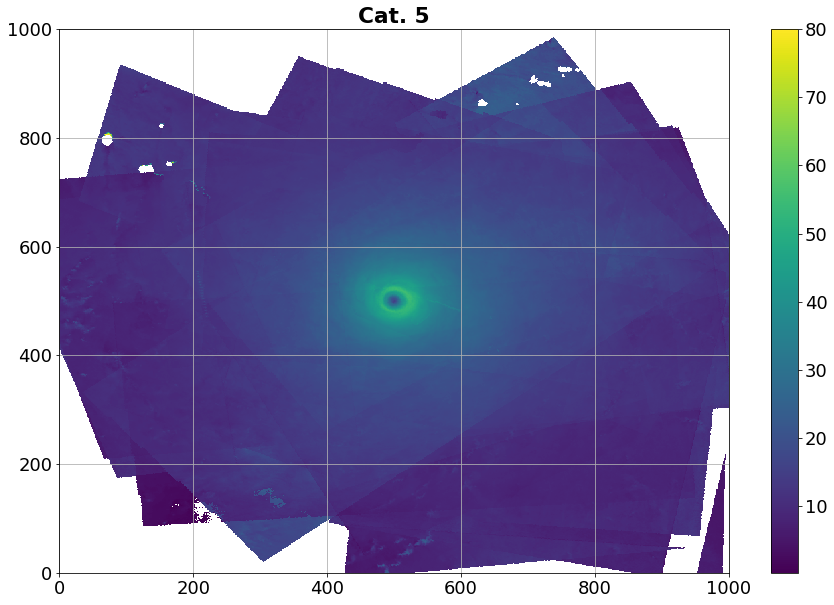

<Figure size 1080x720 with 0 Axes>

In [77]:
### DISPLAY MEAN BY CATEGORY
# Compute
mean_ws_by_cat = []
for cat, ds_cat in ds_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    mean_ws_by_cat.append(np.nanmean(ds_cat['wind_speed'], axis=0))

# Display
for cat, mean_ws in enumerate(mean_ws_by_cat):
    plt.title('Cat. %i'%cat, weight='bold')
    plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()
    plt.show();plt.clf()

In [91]:
### COVARIANCE OF FIRST 10 FIELDS
ds10 = ds_all.isel(time=slice(0, 10))

In [113]:
conc = np.expand_dims(np.array(ds10.isel(time=0)['wind_speed']).flatten(), axis=0)
for i in range(10 - 1):
    i   += 1
    flat = np.expand_dims(np.array(ds10.isel(time=i)['wind_speed']).flatten(), axis=0)
    conc = np.concatenate((conc, flat), axis=0)

In [123]:
conc.shape

(10, 1000000)

In [132]:
z = da.array.cov(conc, rowvar=False)[:10, :10]
# Same
z.compute()

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

In [122]:
gap = conc - np.nanmean(conc, axis=0)
gap.shape

(10, 1000000)

In [126]:
gap[0, :].shape

(1000000,)

In [128]:
gap_multiplied = np.dot(np.expand_dims(gap[0, :], axis=1), np.expand_dims(gap[0, :], axis=0))
gap_multiplied.shape
# ==> Unable to allocate 7 TB for a (1000000 x 1000000) matrix, so we will have to interpolate on a lower-resolution grid. 
# Or use a more clever computation. 
# Or go in r* referential and use 16 points for instance (advantage: we are sure to have Rmax in the included variable).

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

In [124]:
gap_multiplied = np.dot(gap[0, :], gap[0, :])
for i in range(10):
    np.dot(gap[i, :], gap[i, :])

In [121]:
np.dot(gap, gap)

ValueError: shapes (10,1000000) and (10,1000000) not aligned: 1000000 (dim 1) != 10 (dim 0)

In [ ]:
### COVARIANCE BY CATEGORY
# Compute
mean_ws_by_cat = []
for cat, ds_cat in ds_all.groupby('cat'):
    print('Cat. %i ='%cat, ds_cat.dims['time'])
    mean_ws_by_cat.append(np.nanmean(ds_cat['wind_speed'], axis=0))

# Display
for cat, mean_ws in enumerate(mean_ws_by_cat):
    plt.title('Cat. %i'%cat, weight='bold')
    plt.pcolormesh(mean_ws);plt.grid();plt.colorbar()
    plt.show();plt.clf()

In [ ]:
### DISPLAY ALL SOUTHERN HEMISPHERE TCs
# ds2 = ds_all.where(ds_all['lat'][:, 499, 499] < 0)
# ds2['wind_speed'][:, :, :].values
# for time_idx in range(len(ds2.time)):
#     if ds_all['lat'][time_idx, 499, 499] < 0:
#         print(time_idx)
#         plot_wind_field(ds_all, time_idx=time_idx)

In [5]:
### TODO: Interpolate on regular (r, th) grid (OPTIONAL)
### Shift SH TCs ==> Already done
### REMOVE outlier pixels 
### Questions: how many cat.0, cat.1 etc.. do we have? In which basins? Wind field max? Wind speed mean? Average wind field etc...? Average wind field per category? 1D profile? 
### Covariance matrix? 1D covariance? 

In [79]:
import gcsfs

In [90]:
fs = gcsfs.GCSFileSystem(project='alert-ground-261008', token='anon', access='read_only')
fs.ls('project10_tc_sar')

_request non-retriable exception: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401
Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 115, in retry_request
    return await func(*args, **kwargs)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/core.py", line 378, in _request
    validate_response(status, contents, path, args)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 102, in validate_response
    raise HttpError(error)
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401


HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401

In [87]:
fs     = gcsfs.GCSFileSystem(token='anon', access='read_only')
mapper = fs.get_mapper('project10_tc_sar/tc_sar_data.zarr')
ds     = xr.open_zarr(mapper, consolidated=True)

_request non-retriable exception: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object., 401
Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 115, in retry_request
    return await func(*args, **kwargs)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/core.py", line 378, in _request
    validate_response(status, contents, path, args)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 104, in validate_response
    raise HttpError({"code": status, "message": msg})  # text-like
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object., 401


HttpError: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object., 401

In [83]:
fs = gcsfs.GCSFileSystem(project='ds2class', token='anon', access='read_only')
fs.ls('project10_tc_sar')

_request non-retriable exception: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401
Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 115, in retry_request
    return await func(*args, **kwargs)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/core.py", line 378, in _request
    validate_response(status, contents, path, args)
  File "/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/gcsfs/retry.py", line 102, in validate_response
    raise HttpError(error)
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401


HttpError: Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket., 401